<h1>Problem Set 3</h1>
<p>
MACS 30100, Dr. Evans <br>
William L. Guzman     <br> Monday, January 30, 2017 
</p>

<h2>Part 1: Some income data, lognormal distribution, and GMM (6
points).</h2>

<h3>(a) Plot a histogram of percentages of the income.txt data with 30 bins.</h3>

<IPython.core.display.Javascript object>


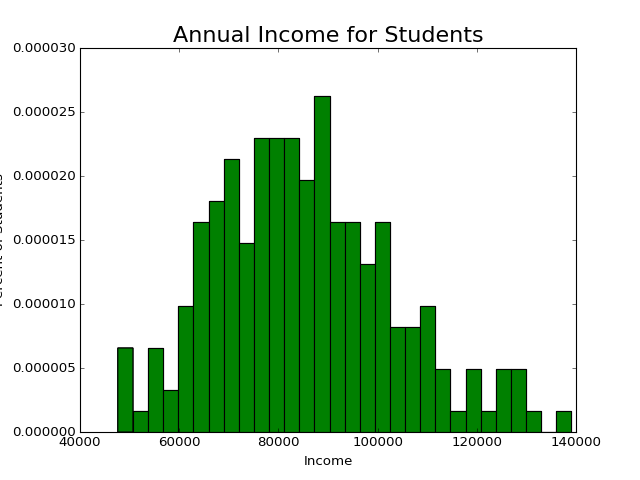

(45000, 140000)

In [2]:
#Import Main Libraries
import os
import numpy as np
import numpy.linalg as lin
import scipy.stats as sts
import scipy.integrate as intgr
import scipy.optimize as opt
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
cmap1 = matplotlib.cm.get_cmap('summer')
%matplotlib notebook

#Change working directory
os.chdir("/home/william/Documents/MACS30100/") 

#Import data using numpy
incomes = np.loadtxt("incomesPS3.txt")

#Plot the histogram with the data in 30 bins.
count, bins, ignored = plt.hist(incomes, 30, normed=True)
plt.title('Annual Income for Students', fontsize=20)
plt.xlabel('Income')
plt.ylabel('Percent of Students')
plt.xlim([45000, 140000]) 

<h3>Part b: Estimate the parameters of the lognormal distribution by generalized method
of moments.</h3>

In [3]:
#Define the different fucntions needed
#Define function that generates values of a truncated normal pdf
def trunc_norm_pdf(xvals, mu, sigma, cutoff):
    if cutoff == 'None':
        prob_notcut = 1.0
  
    else:
        prob_notcut = sts.norm.cdf(cutoff, loc=mu, scale=sigma)
            
        pdf_vals    = ((1/(sigma * np.sqrt(2 * np.pi)) *
                      np.exp( - (xvals - mu)**2 / (2 * sigma**2))) /
                      prob_notcut)
    
    return pdf_vals

#Get mean and variance formula (moments for GMM)
def data_moments(xvals):
    
    mean_data = xvals.mean()
    var_data = xvals.var()
    
    return mean_data, var_data

#Compute the two models moments. 
def model_moments(mu, sigma, cutoff):
    
    xfx = lambda x: x * trunc_norm_pdf(x, mu, sigma, cutoff)
    (mean_model, m_m_err) = intgr.quad(xfx, -np.inf, cutoff)
    x2fx = lambda x: ((x - mean_model) ** 2) * trunc_norm_pdf(x, mu, sigma, cutoff) 
    (var_model, v_m_err) = intgr.quad(x2fx, -np.inf, cutoff)
    
    return mean_model, var_model

#Compute moments of vector errors
def err_vec(xvals, mu, sigma, cutoff, simple):
    
    mean_data, var_data = data_moments(xvals)
    moms_data = np.array([[mean_data], [var_data]])
    mean_model, var_model = model_moments(mu, sigma, cutoff)
    moms_model = np.array([[mean_model], [var_model]])
    
    if simple:
        err_vec = moms_model - moms_data
    
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec

#GMM weighted sum of squared moment errors criterion function
def criterion(params, *args):
    
    mu, sigma = params
    xvals, cutoff, W = args
    err = err_vec(xvals, mu, sigma, cutoff, simple=False)
    crit_val = np.dot(np.dot(err.T, W), err) 
    
    return crit_val

In [4]:
#Perfom the GMM test
mu_init  = np.mean(incomes)
sig_init = np.std(incomes)

params_init = np.array([mu_init, sig_init])

W_hat = np.eye(2)

gmm_args = (incomes, 140000, W_hat)

results = opt.minimize(criterion, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))

mu_GMM1, sig_GMM1 = results.x

print('mu_GMM1=', mu_GMM1, ' sig_GMM1=', sig_GMM1)


mu_GMM1= 85276.8236063  sig_GMM1= 17992.542128


/home/william/anaconda3/lib/python3.5/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  warnings.warn(msg, IntegrationWarning)


<h3>Estimated parameter with the GMM</h3>
<p>mu = 85276.82 <br> 
   sigma = 17992.54
</p>

In [5]:
mean_data, var_data = data_moments(incomes)

mean_model, var_model = model_moments(mu_GMM1, sig_GMM1, 140000)

err1 = err_vec(incomes, mu_GMM1, sig_GMM1, 140000, False).reshape(2,)

#crit_value = criterion()

print('Mean of incomes =', mean_data, ', Variance of incomes =', var_data)
print('Mean of model =', mean_model, ', Variance of model =', var_model)
print('Error vector=', err1)

results

Mean of incomes = 85276.8236063 , Variance of incomes = 323731572.23
Mean of model = 85504.67428129437 , Variance of model = 330456676.6519772
Error vector= [ 0.00267189  0.02077371]


/home/william/anaconda3/lib/python3.5/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  warnings.warn(msg, IntegrationWarning)


      fun: array([[ 0.00043869]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([  2.09749752e-07,   3.37782645e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 3
      nit: 0
   status: 0
  success: True
        x: array([ 85276.82360626,  17992.54212805])

<h3>Criterion function and data models</h3>
<p>
   <b>Mean of incomes</b> = 85276.82 , <b>Variance of incomes</b> = 323731572.23 <br>
   <b>Mean of model</b> = 85504.674 ,<b> Variance of model</b> = 330456676.65<br>
   After calculating the estimated parameters and comparing them to the model estimation, we can see there is not    much different between the two estimations. But the variance is off in both cases. 
</p>

In [6]:
# Plot the histogram of the data
count, bins, ignored = plt.hist(incomes, 30, normed=True)
plt.title('Annual Income for Students', fontsize=20)
plt.xlabel('Income')
plt.ylabel('Percent of Students')
plt.xlim([40000, 140000]) 

#Ploting the PDF Line
dist_incomes = np.linspace(min(incomes),max(incomes),140000)
plt.plot(dist_pts, trunc_norm_pdf(dist_pts, mu_GMM1, sig_GMM1, 450),
        linewidth=2, color='k', label='1: $\mu_{GMM1}$,$\sigma_{GMM1}$')
plt.legend(loc='upper left')

#Plot two step pdf line
dist_incomes = np.linspace(min(incomes),max(incomes),140000)
plt.plot(incomes, trunc_norm_pdf(incomes, mu_GMM2, sig_GMM2, 140000),
        linewidth=2, color='B', label='1: $\mu_{GMM2}$,$\sigma_{GMM2}$')
plt.legend(loc='upper left')



NameError: name 'dist_pts' is not defined

/home/william/anaconda3/lib/python3.5/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  warnings.warn(msg, IntegrationWarning)
/home/william/anaconda3/lib/python3.5/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


<IPython.core.display.Javascript object>


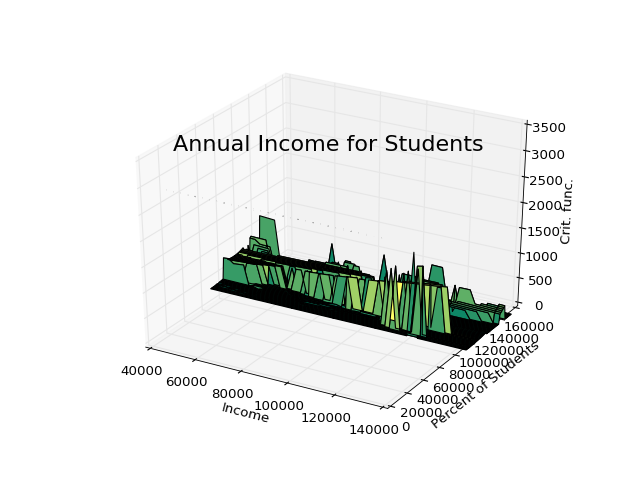

In [6]:
#criterion function 
mu_vals = np.linspace(85000, 145000, 50)
sig_vals = np.linspace(32000, 145000, 50)
# mu_vals = np.linspace(540, 572, 50)
# sig_vals = np.linspace(170, 182, 50)

crit_vals = np.zeros((50, 50))

for mu_ind in range(50):
    for sig_ind in range(50):
        crit_vals[mu_ind, sig_ind] = \
            criterion(np.array([mu_vals[mu_ind], sig_vals[sig_ind]]),
                      incomes, 145000.0, W_hat)

mu_mesh, sig_mesh = np.meshgrid(mu_vals, sig_vals)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(sig_mesh, mu_mesh, crit_vals, rstride=8,
                cstride=1, cmap=cmap1)
ax.set_title('Criterion function for values of mu and sigma')
ax.set_xlabel(r'$\sigma$')
ax.set_ylabel(r'$\mu$')
ax.set_zlabel(r'Crit. func.')


<h2>Part C: Perform the two-step GMM estimator by using your estimates from part
(b) </h2>

In [7]:
#Making the error matrix
err1 = err_vec(incomes, mu_GMM1, sig_GMM1, 1450000.0, False)
VCV2 = np.dot(err1, err1.T) / incomes.shape[0]
print(VCV2)
W_hat2 = lin.pinv(VCV2) 
print(W_hat2)

[[ 0.005  0.005]
 [ 0.005  0.005]]
[[ 50.  50.]
 [ 50.  50.]]


In [8]:
mu_init = mu_GMM1
sig_init = sig_GMM1

params_init = np.array([mu_GMM1, sig_GMM1])
W_hat3 = np.array([[1. / VCV2[0, 0], 0.], [0., 1. / VCV2[1, 1]]])
gmm_args = (incomes, 14500.0, W_hat2)
results = opt.minimize(criterion, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM2, sig_GMM2 = results.x
print('mu_GMM2=', mu_GMM2, ' sig_GMM2=', sig_GMM2)

mu_GMM2= 66231.7828401  sig_GMM2= 57967.8575643


<h3>Two step GMM</h3>
<p>
After using the two step method, our estimate did not improve.<br>
<b>Mean_GMM2 = </b>66231.78<br>
<b>Sigma_GMM2 = </b>57967.86

</p>

In [ ]:
#Plot two step pdf line
dist_incomes = np.linspace(min(incomes),max(incomes),140000)
plt.plot(dist_pts, trunc_norm_pdf(dist_pts, mu_GMM2, sig_GMM2, 140000),
        linewidth=2, color='B', label='1: $\mu_{GMM2}$,$\sigma_{GMM2}$')
plt.legend(loc='upper left')


<h3>Part D: Now estimate the lognormal PDF to fit the data by GMM using different
moments.</h3>

In [16]:
def data_moments4(xvals):
    bpct_1_dat = xvals[xvals < 75000].shape[0] / xvals.shape[0]
    bpct_2_dat = (xvals[(xvals >=75000) & (xvals < 100000)].shape[0] /
                  xvals.shape[0])
    bpct_3_dat = (xvals[(xvals >=100000)].shape[0] /
                  xvals.shape[0])
    

    return bpct_1_dat, bpct_2_dat, bpct_3_dat


def model_moments4(mu, sigma, cutoff):
    
    xfx = lambda x: trunc_norm_pdf(x, mu, sigma, cutoff)
    (bpct_1_mod, bp_1_err) = intgr.quad(xfx, -np.inf, 75000)
    (bpct_2_mod, bp_2_err) = intgr.quad(xfx, 75001, 100000)
    (bpct_3_mod, bp_3_err) = intgr.quad(xfx, 100001, 150000)
   
    
    return bpct_1_mod, bpct_2_mod, bpct_3_mod

def err_vec4(xvals, mu, sigma, cutoff, simple):

    bpct_1_dat, bpct_2_dat, bpct_3_dat, bpct_4_dat = \
        data_moments4(xvals)
    moms_data = np.array([[bpct_1_dat], [bpct_2_dat], [bpct_3_dat]])
                          
    bpct_1_mod, bpct_2_mod, bpct_3_mod= \
        model_moments4(mu, sigma, cutoff)
    moms_model = np.array([[bpct_1_mod], [bpct_2_mod], [bpct_3_mod]])
                          
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = 100 * ((moms_model - moms_data) / moms_data)
    
    return err_vec


def criterion4(params, *args):

    mu, sigma = params
    xvals, cutoff, W = args
    err = err_vec4(xvals, mu, sigma, cutoff, simple=False)
    crit_val = np.dot(np.dot(err.T, W), err) 
    
    return crit_val

In [18]:
print(data_moments4(incomes))
print(model_moments4(75000, 80, 450))
params = np.array([75000, 80])
print(criterion4(params, incomes, 450.0, np.eye(3)))

(0.3, 0.5, 0.2)
(inf, nan, nan)


/home/william/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in double_scalars
/home/william/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in double_scalars
/home/william/anaconda3/lib/python3.5/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


ValueError: not enough values to unpack (expected 4, got 3)

In [19]:
mu_init = 85000
sig_init = 15000
params_init = np.array([mu_init, sig_init])
W_hat = np.eye(4)
# W_hat[1, 1] = 2.0
# W_hat[2, 2] = 2.0
gmm_args = (pts, 450.0, W_hat)
results_4 = opt.minimize(criterion4, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM1_4, sig_GMM1_4 = results_4.x
print('mu_GMM1_4=', mu_GMM1_4, ' sig_GMM1_4=', sig_GMM1_4)

NameError: name 'pts' is not defined